In [1]:
import pandas as pd
from sklearn import metrics
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.csgraph import connected_components
from scipy.sparse.linalg import eigsh
import os
import matplotlib.colors as mcolors 
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import cooler

tool_path = "/home/cstansbu/miniconda3/lib/python3.9/site-packages/"
sys.path.append(tool_path)
import graph_tool.all as gt
print(f"{gt.__version__=}")

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import reconstruction as recon

/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/cstansbu/miniconda3/lib/python3.9/site-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)


gt.__version__='2.58 (commit c513b9b6, )'
gt.__version__='2.58 (commit c513b9b6, )'


A.shape=(196, 196)
A.shape=(193, 193)


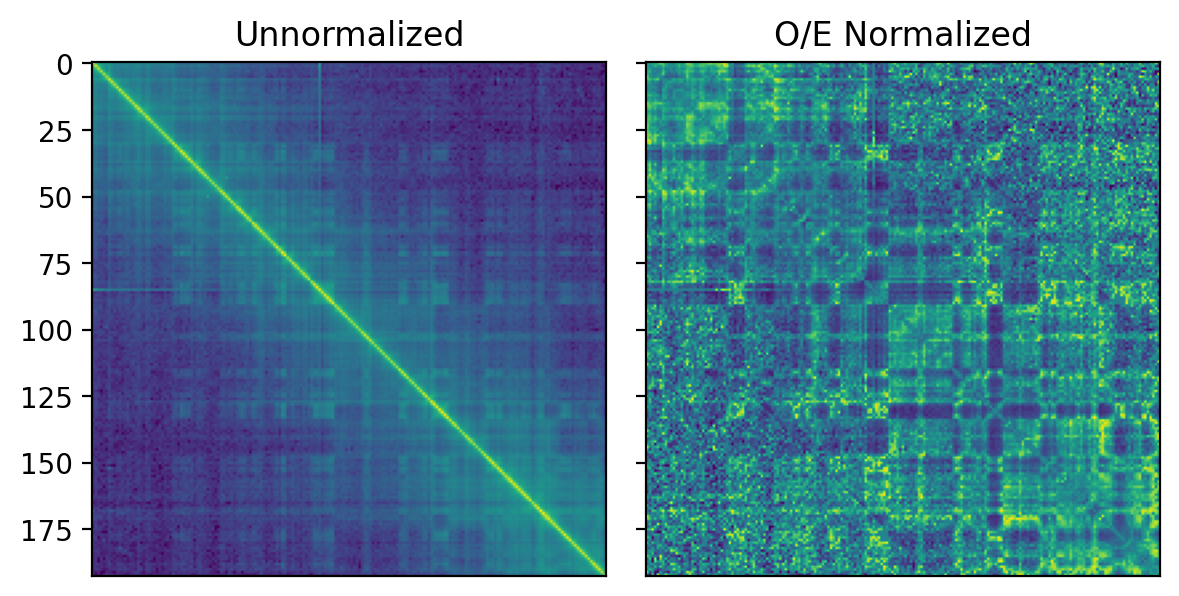

In [9]:
reload(matrix)
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_hic/chr1_1000000.csv"

df  = pd.read_csv(fpath)
A = df.to_numpy()
print(f"{A.shape=}")

# drop the telomere
A = A[3:, :][:, 3:]
print(f"{A.shape=}")

Anorm = matrix.normalize_oe(matrix.normalize_kr(A).todense())


# correct outliers
top = 500
row_idx, col_idx = matrix.get_sorted_upper_triangle_indices(Anorm)

# update the matrix 
for i in range(top):
    Anorm[row_idx[i], col_idx[i]] = Anorm.mean()


# visualize
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].imshow(np.log1p(A))
axs[1].imshow(Anorm)

axs[0].set_title('Unnormalized')
axs[1].set_title('O/E Normalized')

axs[0].set_xticks([])
axs[1].set_xticks([])

plt.tight_layout()

Input network thresholded at threshold=1.2 has 1 connected component(s)


([], [])

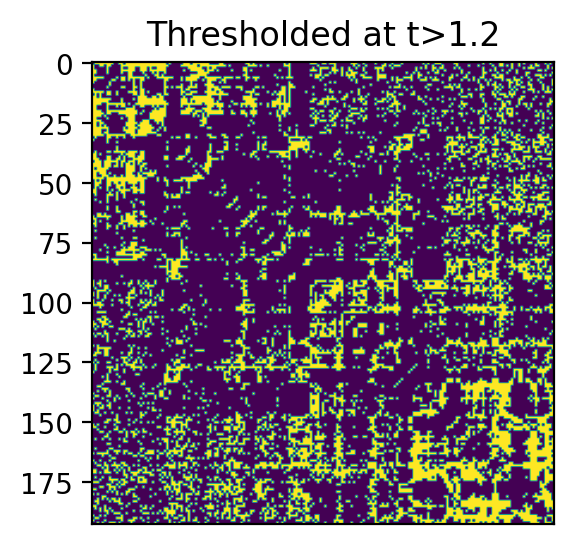

In [15]:
threshold = 1.2
Ahat = np.where(Anorm > threshold, 1, 0)
num_components, _ = connected_components(Ahat, directed=False)
print(f"Input network thresholded at {threshold=} has {num_components} connected component(s)")

g = recon.create_graph_tools_from_adjacency(Ahat)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.imshow(Ahat)
plt.title(f"Thresholded at t>{threshold}")
plt.xticks([])

# Learn Higher-Order Structure

In [23]:
hyperedges = recon.learn_hyperedges_mcmc(g, niter=200)
print(f"{len(hyperedges)=}")

len(hyperedges)=912


I.shape=(193, 912)


Text(0.5, 1.0, 'All Inferred Hyperedges from Hi-C')

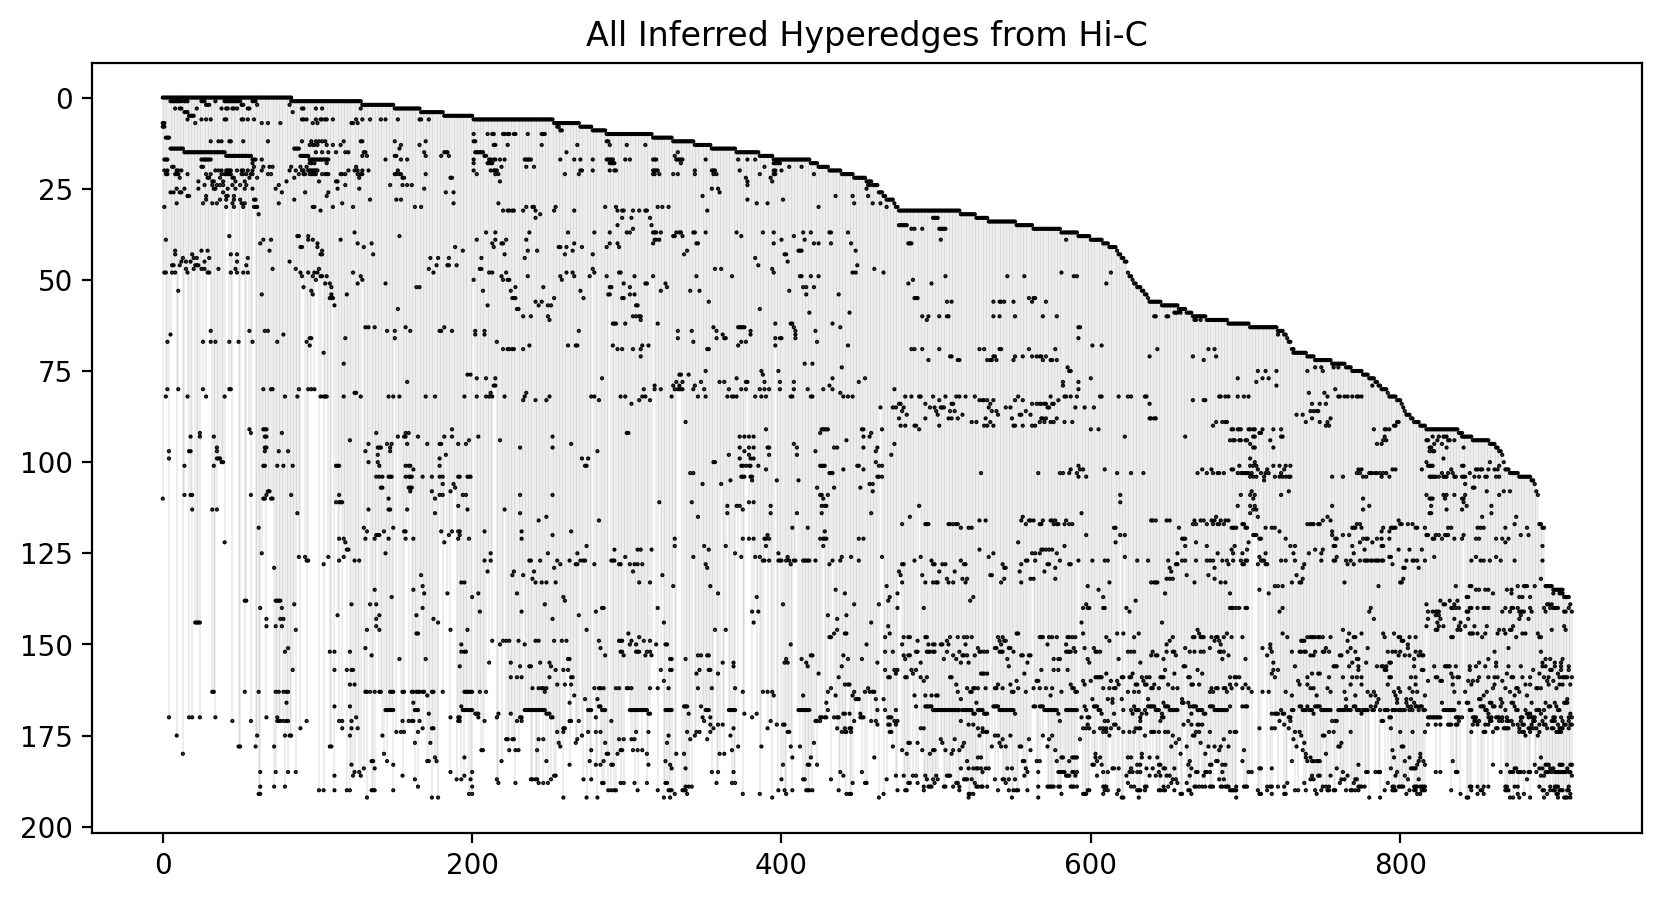

In [25]:
reload(ut)
I = ut.list_of_list_to_incidence(hyperedges)
df = pd.DataFrame(I)
print(f"{I.shape=}")

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(df),
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"All Inferred Hyperedges from Hi-C")

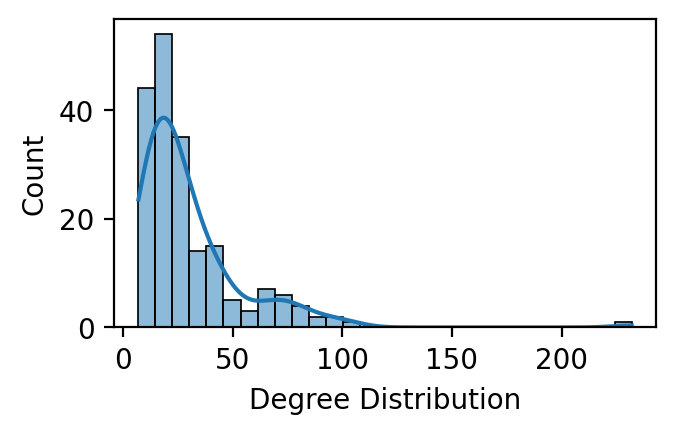

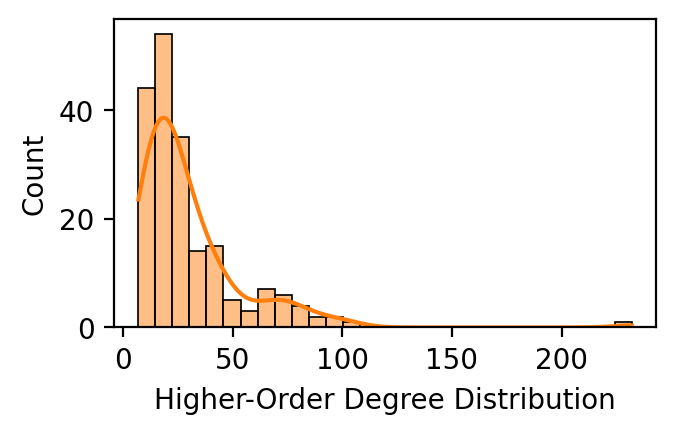

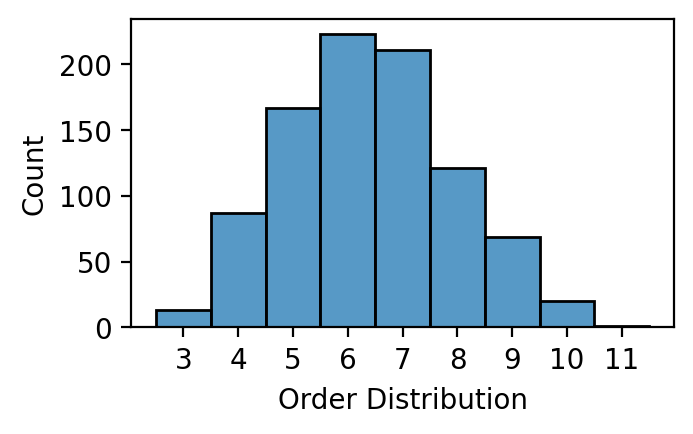

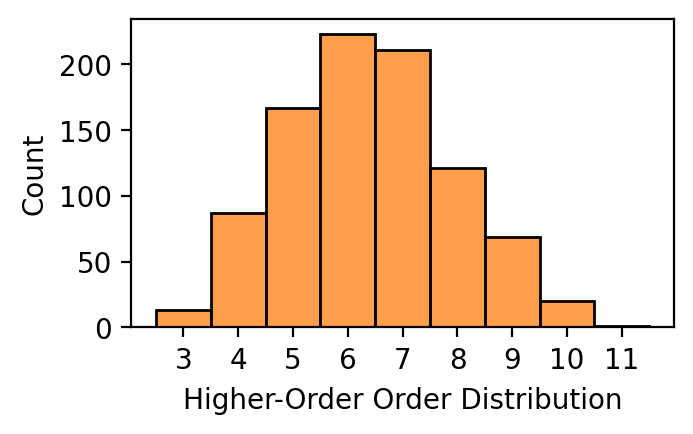

In [26]:
degrees = df.sum(axis=1)
orders = df.sum(axis=0)

# get the degree of higher order contacts
high_order_idx = np.argwhere(orders.values > 2).ravel()
ho_degrees = df[df.columns[high_order_idx]].sum(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

sns.histplot(x=degrees,
             kde=True)

plt.xlabel('Degree Distribution')
plt.show()

sns.histplot(x=ho_degrees,
             kde=True,
             color="C1")

plt.xlabel('Higher-Order Degree Distribution')
plt.show()



sns.histplot(x=orders,
             discrete=True)

plt.gca().set_xticks(sorted(np.unique(orders)))
plt.xlabel('Order Distribution')
plt.show()


sns.histplot(x=orders[orders.values > 2],
             discrete=True,
             color="C1")

plt.gca().set_xticks(sorted(np.unique(orders)))
plt.xlabel('Higher-Order Order Distribution')
plt.show()